# Aicraft recognition system

This is a model to recognize aircraft models based on pictures.

Necessary imports

In [135]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Function to annotation files on pandas dataframes

In [136]:
def load_annotation(filename, labelname):
    file_list = []

    with open(filename) as file:
        for line in file:
            line = line.split()
            imagefilename = line[0] + ".jpg"
            label = " ".join(line[1:])
            file_list.append([imagefilename, label])

    dataframe = pd.DataFrame(file_list)
    dataframe.columns = ["File", labelname]
    return dataframe

Now I load the annotation files

In [137]:
annotations_path = "../fgvc-aircraft-2013b/data"

manufacturers_train_file = os.path.join(annotations_path, "images_manufacturer_trainval.txt")
manufacturers_test_file = os.path.join(annotations_path, "images_manufacturer_test.txt")
family_train_file = os.path.join(annotations_path, "images_family_trainval.txt")
family_test_file = os.path.join(annotations_path, "images_family_test.txt")
variant_train_file = os.path.join(annotations_path, "images_variant_trainval.txt")
variant_test_file = os.path.join(annotations_path, "images_variant_test.txt")

manufacturers_train = load_annotation(manufacturers_train_file, "Manufacturer")
manufacturers_test = load_annotation(manufacturers_test_file, "Manufacturer")
family_train = load_annotation(family_train_file, "Family")
family_test = load_annotation(family_test_file, "Family")
variant_train = load_annotation(variant_train_file, "Variant")
variant_test = load_annotation(variant_test_file, "Variant")

Simple function to show images

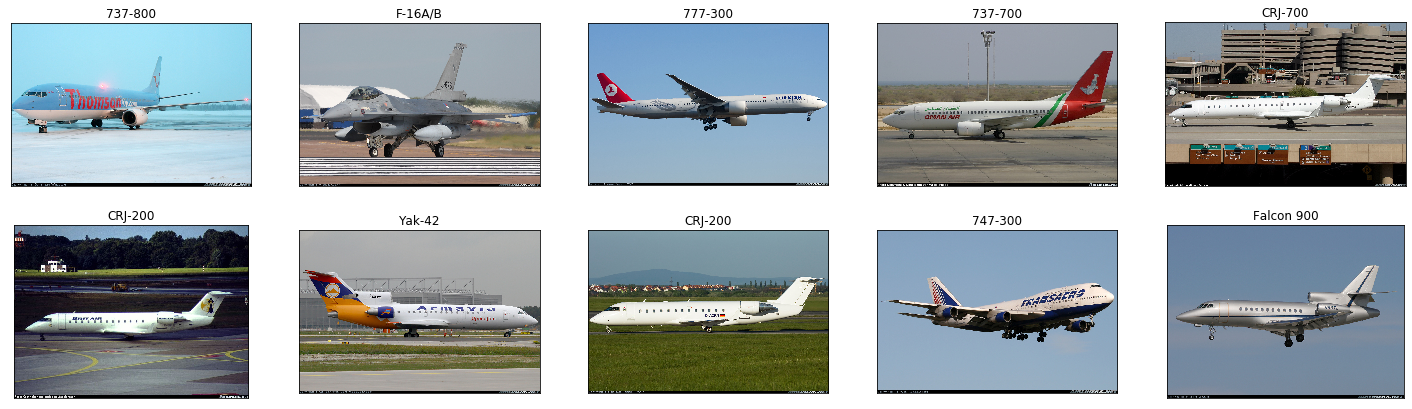

In [138]:
images_path = "../fgvc-aircraft-2013b/data/images"
samples_num = 10
sample = variant_train.sample(samples_num)

fig = plt.figure(figsize=(25,7))

for (_, image), idx in zip(sample.iterrows(), range(samples_num)):
    axes = fig.add_subplot(2, samples_num/2, idx+1, xticks=[], yticks=[])
    plt.imshow(io.imread(os.path.join(images_path, image["File"])))
    axes.set_title(image["Variant"])

## Defining the dataset class

Now we are going to write a custom dataset, since our data is not organized by folder/class as usual.

For this, I used the custom dataset tutorial available at:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [139]:
class AircraftDataset(Dataset):
    
    def __init__(self, dataframe, images_dir, transform=None):
        """ 
            Args:
            pd.DataFrame dataframe: A dataframe with the name of the image files and the label of the image
            str images_dir: The directory where the images a stored
            callable, optional transform: The transformations to be applied to the images
        """
        self.aircraft_dataframe = dataframe
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.aircraft_dataframe)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = io.imread(os.path.join(self.images_dir, self.aircraft_dataframe.iloc[idx, 0]))
        label = self.aircraft_dataframe.iloc[idx, 1]
            
        sample = {'image': image, 'label': label}
                 
        if self.transform:
            sample = self.transform(sample)
            
        return sample

Now we will set the transformations for data augmentation and for compatibility with the pre-trained models

In [140]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip,
                                transforms.RandomRotation(10),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

### Create the datasets and dataloaders

In [141]:
manufacturers_train_dataset = AircraftDataset(manufacturers_train, images_path, transform)
manufacturers_test_dataset = AircraftDataset(manufacturers_test, images_path, transform)
family_train_dataset = AircraftDataset(family_train, images_path, transform)
family_test_dataset = AircraftDataset(family_test, images_path, transform)
variant_train_dataset = AircraftDataset(variant_train, images_path, transform)
variant_test_dataset = AircraftDataset(variant_test, images_path, transform)

In [142]:
batch_size = 10

manufacturers_train_dataloader = DataLoader(manufacturers_train_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=0)
manufacturers_test_dataloader = DataLoader(manufacturers_test_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=0)
family_train_dataloader = DataLoader(family_train_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=0)
family_test_dataloader = DataLoader(family_test_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=0)
variant_train_dataloader = DataLoader(variant_train_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=0)
variant_test_dataloader = DataLoader(variant_test_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=0)

### Function to show a batch of images

In [143]:
def show_images_batch(sample_batch):
    """Show images of a batch of images"""
    
    images_batch, labels_batch = sample_batch['image'], sample_batch['label']
    batch_size = len(images_batch)
    
    fig = plt.figure(figsize=(25,7))

    for image, lable in zip(images_batch, labels_batch):
        axes = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
        plt.imshow(image)
        axes.set_title(label)

In [144]:
show_images_batch(next(iter(variant_train_dataloader)))

RuntimeError: stack expects each tensor to be equal size, but got [903, 1400, 3] at entry 0 and [812, 1200, 3] at entry 1